<a href="https://colab.research.google.com/github/akitim/Motorica_Gesture_Classification_Task/blob/main/Motorica_gesture_classification_2nd_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Настройка окружения

In [1]:
# !wget https://drive.google.com/file/d/1fpfP68Xmi3DUpCUCNz7gErnd6ndEB9ug/view?usp=sharing -P /content/
%cd /content/
!git clone https://github.com/akitim/Motorica_Gesture_Classification_Task

# %cd /content/Motorica_Gesture_Classification_Task
# !git remote set-url origin https://github.com/akitim/Motorica_Gesture_Classification_Hackathon

/content
Cloning into 'Motorica_Gesture_Classification_Task'...
remote: Enumerating objects: 218, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 218 (delta 56), reused 1 (delta 1), pack-reused 127
Receiving objects: 100% (218/218), 77.88 MiB | 10.39 MiB/s, done.
Resolving deltas: 100% (118/118), done.


### Загрузка библиотек

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.signal import savgol_filter
from scipy.signal import convolve
from scipy.fftpack import rfft, fftfreq
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_rows", 100, "display.max_columns", 9)

### Функции

In [3]:
def gaussian_norm(x, *p):
    mu, sigma = p
    return 1 / (sigma * np.sqrt(2. * np.pi)) * np.exp(-(x - mu)**2/(2.*sigma**2))

def autocorr_with_lags(x):
    result = correlate(x, x, mode='full')
    lags = correlation_lags(x.size, x.size, mode='full')
    return (lags[lags.size//2:], result[result.size//2:])

### Загрузка данных

In [4]:
X_submit = np.load('/content/Motorica_Gesture_Classification_Task/data_2nd_task/'
                   'X_test_2.npy')
X = np.load('/content/Motorica_Gesture_Classification_Task/data_2nd_task/'
            'X_train_2.npy')
    
sample_submission = \
    pd.read_csv('https://raw.githubusercontent.com/akitim/'
        'Motorica_Gesture_Classification_Task/main/data_2nd_task/'
        'sample_submission_2.csv')
y = \
    pd.read_csv('https://raw.githubusercontent.com/akitim/'
        'Motorica_Gesture_Classification_Task/main/data_2nd_task/y_train_2.csv')

In [5]:
print(f'Shape of X: {X.shape}\nShape of y: {y.shape}')

Shape of X: (323, 40, 100)
Shape of y: (32300, 2)


* 0 - команда "жест open";
* 1 - команда "сгиб мизинца";
* 2 - команда "сгиб безымянного пальца";
* 3 - команда "сгиб среднего пальца";
* 4 - команда "жест пистолет";
* 5 - команда "сгиб указательного пальца";
* 6 - команда "сгиб большога пальца";
* 7 - команда "жест ОК";
* 8 - команда "жест grab";

In [ ]:
# y[y['class']==1].iloc[:, :]
classes_counts = y['class'].value_counts()
classes = pd.DataFrame({'gesture': ['open', 'pinky bend', 'middle bend',
                                    'ring bend', 'pistol', 'index bend',
                                    'thumb bend', 'OK', 'grab'],
                        'class': classes_counts.index,
                        'counts': classes_counts.values
})
classes

gesture  class  counts
0         open      0   17950
1   pinky bend      6    1800
2  middle bend      5    1800
3    ring bend      3    1800
4       pistol      2    1800
5   index bend      1    1800
6   thumb bend      8    1800
7           OK      7    1800
8         grab      4    1750

In [ ]:
# нормализуем X и X_submit на 4096
print(f"до: {X[0, 0, 0:10]} ")
X /= 4096
X_submit /= 4096

print(f'после: {X[0, 0, 0:10]}')

до: [1123. 1125. 1121. 1120. 1115. 1112. 1111. 1111. 1113. 1106.] 
после: [0.27416992 0.2746582  0.27368164 0.2734375  0.2722168  0.27148438
 0.27124023 0.27124023 0.27172852 0.27001953]


In [ ]:
# data = pd.DataFrame()
# X.reshape()
M = np.array(
    [
    [[1, 2, 3, 3.5], 
     [4, 5, 6, 6.5],
     [7, 8, 9, 9.5]
     ],
    [[10, 20, 30, 35], 
     [40, 50, 60, 65],
     [70, 80, 90, 95]
     ]
]) #(2, 3, 4)
M_ = np.zeros((M.shape[1], M.shape[0]*M.shape[2]))
print(M_.shape)

for i in range(M.shape[1]):
    M_[i] = M[:, i,  :].ravel()
pd.DataFrame(M_.T)

M.swapaxes(1, 2)

(3, 8)


array([[[ 1. ,  4. ,  7. ],
        [ 2. ,  5. ,  8. ],
        [ 3. ,  6. ,  9. ],
        [ 3.5,  6.5,  9.5]],

       [[10. , 40. , 70. ],
        [20. , 50. , 80. ],
        [30. , 60. , 90. ],
        [35. , 65. , 95. ]]])

## Визуализация: жесты и сигнал

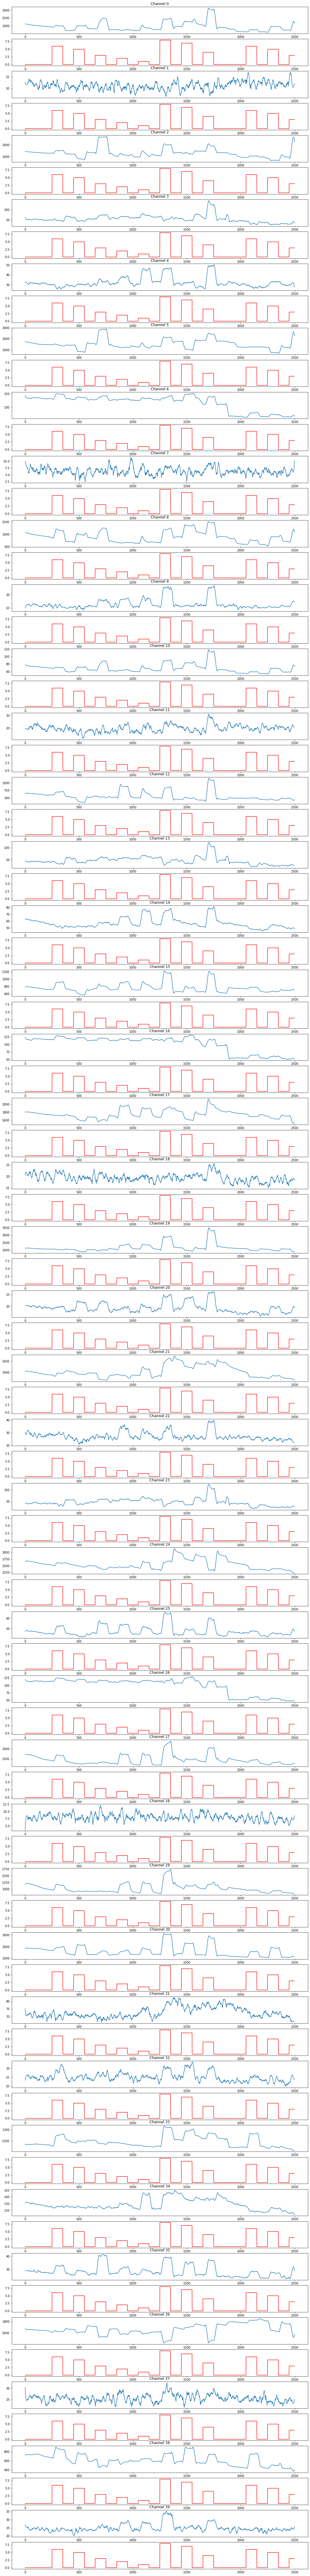

In [ ]:
p = 25
fig, axs = plt.subplots(80, 1, figsize=(18, 2*2*40));
for i in range(0, 80, 2):
    X_smoothed = savgol_filter(X[0:p, i//2, :].ravel(), 41, 3)
    axs[i].plot(X_smoothed[0:p*100]);
    axs[i + 1].plot(y['class'][0:p*100], c='r');
    axs[i].set_title(f'Channel {i//2}', )
    plt.shareX=True

# [1, 7, 11, 18, 28, 31, 32, 37, 39]

## Детекция каналов без полезного сигнала

### Попытка №1: свертка распределения сигнала с гауссианой

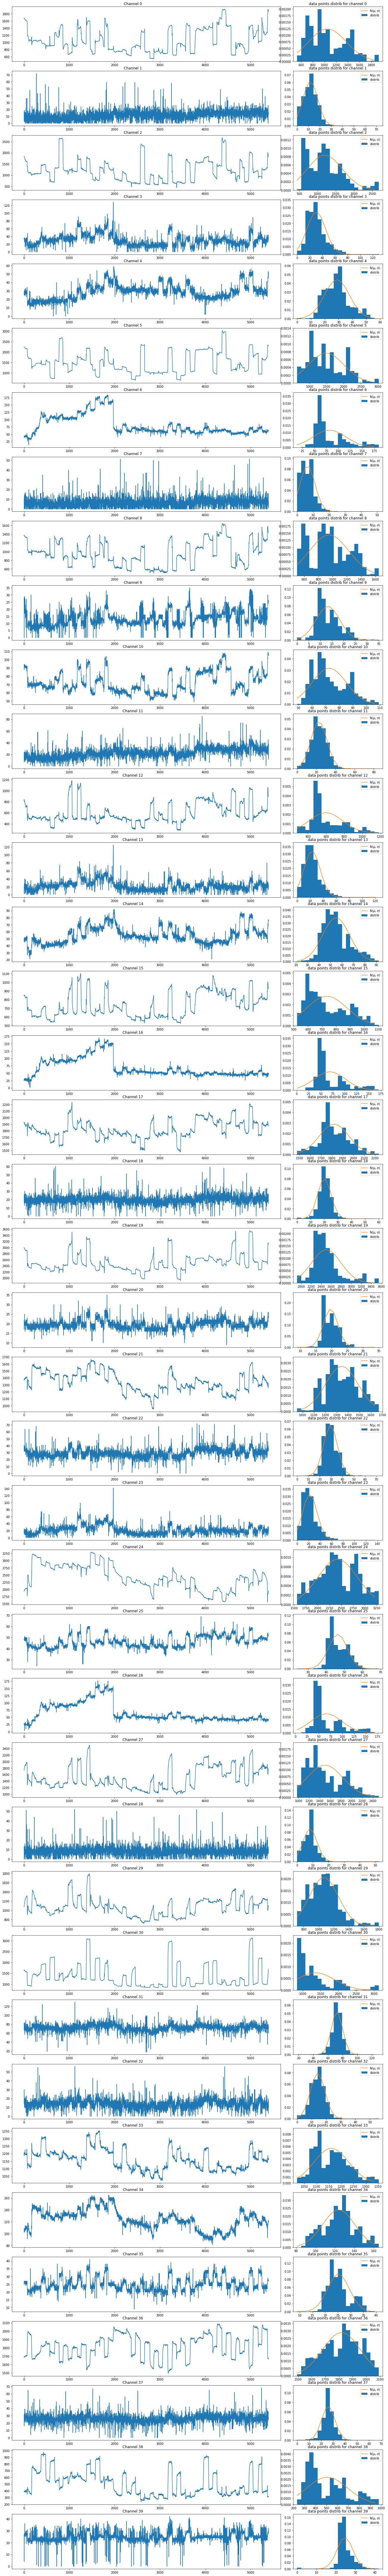

In [ ]:
from scipy.signal import convolve

def gaussian_norm(x, *p):
    mu, sigma = p
    return 1 / (sigma * np.sqrt(2. * np.pi)) * np.exp(-(x - mu)**2/(2.*sigma**2))

start = 0
end = 54
fig, axs = plt.subplots(nrows=40, ncols=2, figsize=(18, 1*3*40),
                        gridspec_kw={'width_ratios': [3, 1]});
fig.tight_layout()

gauss_residues = []
for i in range(0, 40, 1):
    X_submit_smoothed = X_submit[start:end, i, :].ravel() #savgol_filter(X_submit[start:end, i, :].ravel(), 21, 3)
    axs[i, 0].plot(X_submit_smoothed[start*100:end*100]);
    h = axs[i, 1].hist(X_submit_smoothed[start*100:end*100], bins=20, density=True, label='distrib');
    
    mu_X, sigma_X = X_submit_smoothed.mean(), X_submit_smoothed.std()
    g_curve = gaussian_norm(h[1][:-1], mu_X, sigma_X)
    axs[i, 1].plot(h[1][:-1], g_curve, label='N(µ, σ)');

    gauss_residues += [convolve(h[0], g_curve)]

    axs[i, 1].legend();
    axs[i, 0].set_title(f'Channel {i}                       ')
    axs[i, 1].set_title(f'data points distrib for channel {i}')
    plt.shareX=True

# X_submit.shape
def signal_distrib_visualization(signal=None, ):
    pass

In [ ]:
# plt.plot(np.array(gauss_residues)**2);
gr_sqrd = (np.array(gauss_residues)).sum(axis=1)*(h[1].max() - h[1].min()) / 20
# gr_sqrd = gr_sqrd / gr_sqrd.min()
gr_sqrd_dict = [(i, gr_sqrd[i]) for i in range(40)]
# gr_sqrd_dict
noisy = sorted(gr_sqrd_dict, reverse=True, key = lambda t: t[1])
# np.round(gr_sqrd, 2)
# np.array(gauss_residues).shape

In [ ]:
start = 0
end = 54
n_to_show = 20

fig, axs = plt.subplots(nrows=n_to_show, ncols=1, figsize=(18, 1*3*n_to_show));
fig.tight_layout();

axs_g = (ax for ax in axs)

for i in [pair[0] for pair in noisy][0:n_to_show]:
    X_submit_smoothed = X_submit[start:end, i, :].ravel() #savgol_filter(X_submit[start:end, i, :].ravel(), 21, 3)
    ax_curr = next(axs_g)
    ax_curr.plot(X_submit_smoothed[start*100:end*100]);
    ax_curr.set_title(f'Channel {i}                       ')
    plt.shareX=True

### Попытка №2: анализ спектра плотности мощности сигнала

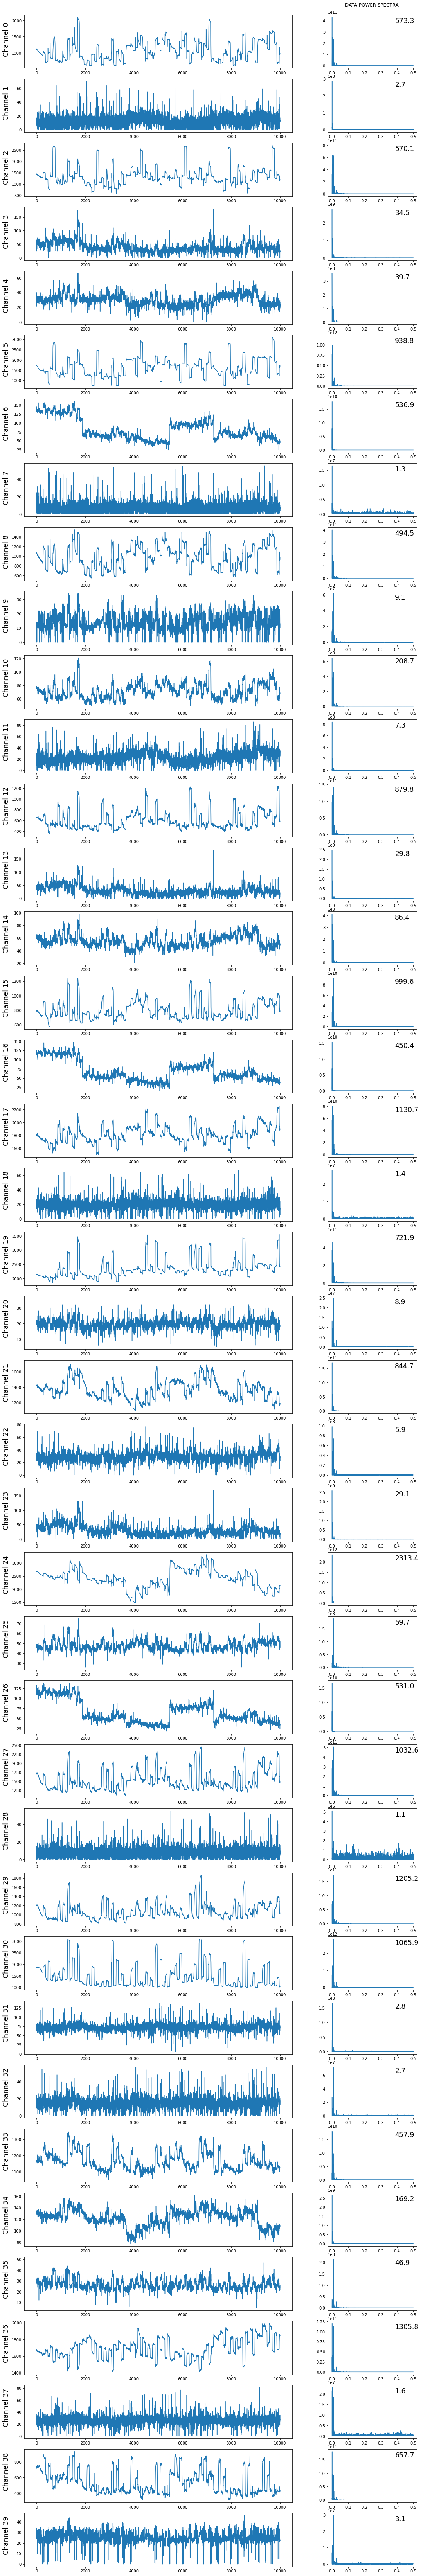

In [8]:
start = 0
end = 100
n_to_show = 40

fig, axs = plt.subplots(nrows=n_to_show, ncols=2, figsize=(18, 1*3*n_to_show),
                        gridspec_kw={'width_ratios': [3, 1]});
# fig.tight_layout()

spectra = []
CRIT = []
for i in range(0, n_to_show, 1):
    X_submit_smoothed = X[start:end, i, :].ravel() #savgol_filter(X_submit[start:end, i, :].ravel(), 21, 3)
    
    freq = fftfreq(X_submit_smoothed.size, d=1)
    freq = freq[0:freq.size//2] # берем только положительные частоты
    spectra += [(rfft(X_submit_smoothed - X_submit_smoothed.mean())**2)[0:freq.size]]
    
    freq_threshold = .15
    freq_threshold_ind = freq[freq <= freq_threshold].size
    CRIT += [spectra[i][:freq_threshold_ind].sum() /\
     (freq <= freq_threshold).sum() / spectra[i][freq_threshold_ind:].sum() *\
      (freq > freq_threshold).sum()]

    axs[i, 0].plot(np.arange(start*100, end*100, 1),
                   X_submit_smoothed[0:(end - start)*100]);
    axs[i, 1].plot(freq, spectra[i], label='');

    axs[i, 0].text(-0.08, 0.25, f'Channel {i}', rotation=90,
                   transform=axs[i, 0].transAxes, fontsize='xx-large')
    axs[i, 1].text(0.75, 0.85, f'{np.round(CRIT[i], 1)}', rotation=0,
                   transform=axs[i, 1].transAxes, fontsize='xx-large')
    if not i: axs[i, 1].set_title(f'DATA POWER SPECTRA \n')
    plt.shareX=True

In [ ]:
sorted(list(map(lambda x: round(x, 1), CRIT)))

### Попытка №3. Автокорреляция

In [ ]:
from scipy.signal import correlate, correlation_lags

start = 4.5
end = 5.5
n_to_show = 4

fig, axs = plt.subplots(nrows=n_to_show, ncols=2, figsize=(18, 1*3*n_to_show),
                        gridspec_kw={'width_ratios': [3, 1]});
# fig.tight_layout()

# autocorr = []
for i in range(0, n_to_show, 1):
    X_submit_smoothed = X[start//1 : end//1 + end%1>0, i, :].\
        ravel()[int(start%1):int(end%1)] #savgol_filter(X_submit[start:end, i, :].ravel(), 21, 3)
    
    lags, autocorr = autocorr_with_lags(X_submit_smoothed)
    
    axs[i, 0].plot(np.arange(start*100, end*100, 1),
                   X_submit_smoothed[0:int(end - start)*100]);
    axs[i, 1].scatter(lags[0:10], autocorr[0:10])

    axs[i, 0].text(-0.08, 0.25, f'Channel {i}', rotation=90,
                   transform=axs[i, 0].transAxes, fontsize='xx-large')
    # axs[i, 1].text(0.75, 0.85, f'{np.round(1, 1)}', rotation=0,
    #                transform=axs[i, 1].transAxes, fontsize='xx-large')
    if not i: axs[i, 1].set_title(f'Autocorrelation \n')
    plt.shareX=True

In [24]:
int(0.5)

0

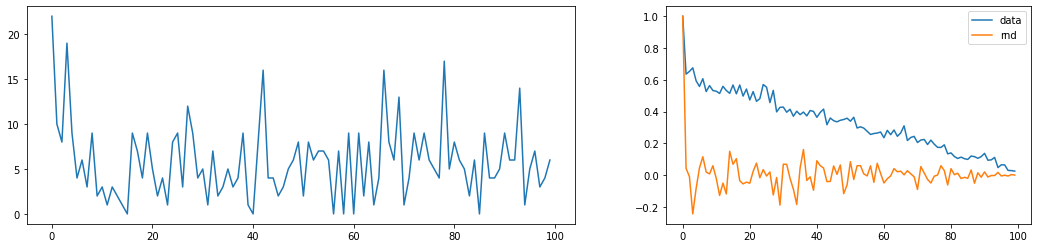

In [27]:
from scipy.signal import correlate, correlation_lags

def autocorr_with_lags(x):
    result = correlate(x, x, mode='full')
    lags = correlation_lags(x.size, x.size, mode='full')
    return (lags[lags.size//2:], result[result.size//2:])

start = 2
end = 4

rnd = np.random.normal(size=100)
z = X[18:19, 7, :].ravel()
# z /= z.max()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 4),
                        gridspec_kw={'width_ratios': [3, 2]});
axs[0].plot(z);

rnd_ac = list(autocorr_with_lags(rnd))
rnd_ac[1] /= rnd_ac[1].max()

z_ac = list(autocorr_with_lags(z))
z_ac[1] /= z_ac[1].max()

axs[1].plot(*z_ac, label='data');
axs[1].plot(*rnd_ac, label='rnd');
axs[1].legend();

In [32]:
z

array([[ 6.,  5.,  8.,  3.,  4., 11.,  8.,  0., 18., 11.,  8.,  4., 14.,
         5., 10.,  6.,  2.,  0.,  9.,  6., 13.,  4., 12.,  3.,  0.,  7.,
        10.,  4., 12.,  5.,  7.,  1.,  8., 11.,  0.,  9., 13.,  4., 50.,
         5.,  5.,  0., 10.,  6., 11.,  5.,  9., 16.,  8.,  6.,  2., 10.,
         3., 13., 10.,  7., 12.,  8.,  9.,  9.,  0.,  6., 13.,  6.,  3.,
         7.,  9.,  8., 20., 18.,  7., 17., 13.,  5., 14., 14., 16.,  5.,
         8.,  0., 10., 19.,  5.,  6.,  8., 16., 13.,  6.,  1., 18.,  4.,
         6.,  8.,  8.,  8., 12.,  4.,  0.,  5.,  7.]])

In [ ]:
import scipy
scipy.__version__

'1.7.3'

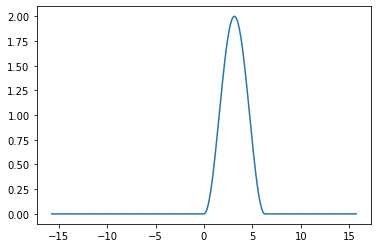

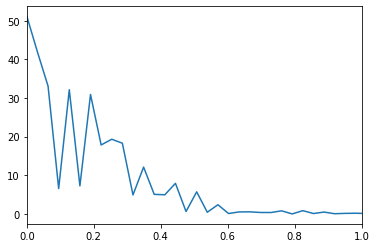

In [ ]:
a = -0.1
b = 0.1
# plt.plot(freq[freq.size//3:freq.size//2], (spectra[0][freq.size//3:freq.size//2]));
# plt.plot(freq[0:220], np.abs(spectra[0][0:220]));

# xx = np.linspace(-15, 15, 256)
xx = np.linspace(-5*np.pi, 5*np.pi, 256)
# g_curve = gaussian_norm(xx, 0, 2)
g_curve = np.asarray([np.sin(1.*x - np.pi/2) + 1 if np.abs(x - np.pi) <= np.pi else 0 for x in xx])
plt.plot(xx, g_curve);
plt.show()

f = fftfreq(g_curve.size, d=xx[1] - xx[0])
f_hv = f[0:f.size//2]

g_curve_fft = rfft(g_curve)
g_curve_fft_hv = savgol_filter(g_curve_fft[0:f.size//2], 9, 7)

plt.plot(f_hv, np.abs(g_curve_fft_hv));
# plt.xlim(0, 25);
plt.xlim(0, 1);
plt.shareX = True;

128

# Характеристика датасета

In [ ]:
X.shape, y.shape, X_submit.shape

((323, 40, 100), (32300, 2), (54, 40, 100))

## Классы (y)

In [ ]:
y.sample(5)

Id  Class
1      1      8
13    13     12
69    69     11
159  159      0
25    25      7

Количество объектов каждого класса:

In [ ]:
y['class'].value_counts().sort_index()

0    17950
1     1800
2     1800
3     1800
4     1750
5     1800
6     1800
7     1800
8     1800
Name: class, dtype: int64

In [ ]:
print(f'X_submit shape: {X_submit.shape}\n')
sample_submission.sample(2)

X_submit shape: (166, 40, 60)



Id  Class
144  309     12
79   244      6

In [ ]:
def del_emty_axes(axs):
    # удаляем пустые графики
    for axes in axs.flatten():
        if not(axes.has_data()):
            fig.delaxes(axes)
    return None

# def SG_smooth(data=None, window=10, order=3):
#     return np.asarray([savgol_filter(x=channel, window_length=window, polyorder=order) \
#                       for channel in [X for X in X]])

##Удаляем каналы без сигнала

In [ ]:
def remove_channels(data=None, n_channels=40, channels_to_remove=[]):
    
    channels_to_remove_mask = np.ones(n_channels, dtype=bool)
    channels_to_remove_mask[channels_to_remove] = False
    
    return data[:, channels_to_remove_mask, :].copy()

num_of_channels = X.shape[1] #40
channels_to_remove = [1, 7, 11, 18, 28, 31, 32, 37, 39]

X_proc = remove_channels(data=X,
                               n_channels=num_of_channels,
                               channels_to_remove=channels_to_remove)
X_submit_proc = remove_channels(data=X_submit,
                               n_channels=num_of_channels,
                               channels_to_remove=channels_to_remove)
print(X_submit.shape, X_submit_proc.shape)

# X_proc = savgol_filter(X_proc, 7, 2)
# X_submit_proc = savgol_filter(X_submit_proc, 7, 3)

print(X_proc.shape, X_submit_proc.shape)

(166, 40, 60) (166, 31, 60)
(165, 31, 60) (166, 31, 60)


##Формируем признаки

In [ ]:
X_ = np.mean(X_proc[:, :, 0:30], axis=2)\
    - np.mean(X_proc[:, :, 50:60], axis=2)

X_submit_ = np.mean(X_submit_proc[:, :, 0:15], axis=2)\
    - np.mean(X_submit_proc[:, :, 45:60], axis=2)

#стандартизируем
std_scaler = StandardScaler()
X_ = std_scaler.fit_transform(X_)
X_submit_ = std_scaler.transform(X_submit_)

y_true = y.Class.values

## Строим модель

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(
    X_, y_true, test_size=0.1,
    random_state=RANDOM_SEED
)

Cs = np.logspace(-2, 3, 4)
l1_ratios = [0, 0.25, 0.5, 0.75, 1]

params = {'Cs': Cs,
          'cv': 2,
          'penalty': 'elasticnet', #['l1', 'l2']
          'scoring': 'f1_macro',
          'solver': 'saga',
          'tol': 0.0001,
          'max_iter': 1000,
          'n_jobs': -1,
          'multi_class': 'multinomial',
          'random_state': RANDOM_SEED,
          'l1_ratios': l1_ratios
}

logreg = LogisticRegressionCV(**params)
logreg.fit(X=X_train, y=y_train)

y_pred = logreg.predict(X_test)

print (f"Средняя F-мера: {f1_score(y_test, y_pred, average='macro')}")

Средняя F-мера: 0.8461538461538461


In [ ]:
# pd.Series(y_test).value_counts()
y_test[y_test==1]

array([1, 1])

## Submit

In [ ]:
y_submit = logreg.predict(X_submit_)

submission = pd.DataFrame({'Id': sample_submission.Id.values, 'Class': y_submit})

# submission_str = 'Id,Class'
# for q in range(166):
#     submission_str += '\n' + str(q) + ',' + str(y_submit[q])  

# with open ('submission.csv', 'w', encoding="utf-8") as submission_file:
#     submission_file.write(submission_str)

submission_file.close()

submission.to_csv('/content/submission.csv', index=False)

## Развертка жестов по каналам

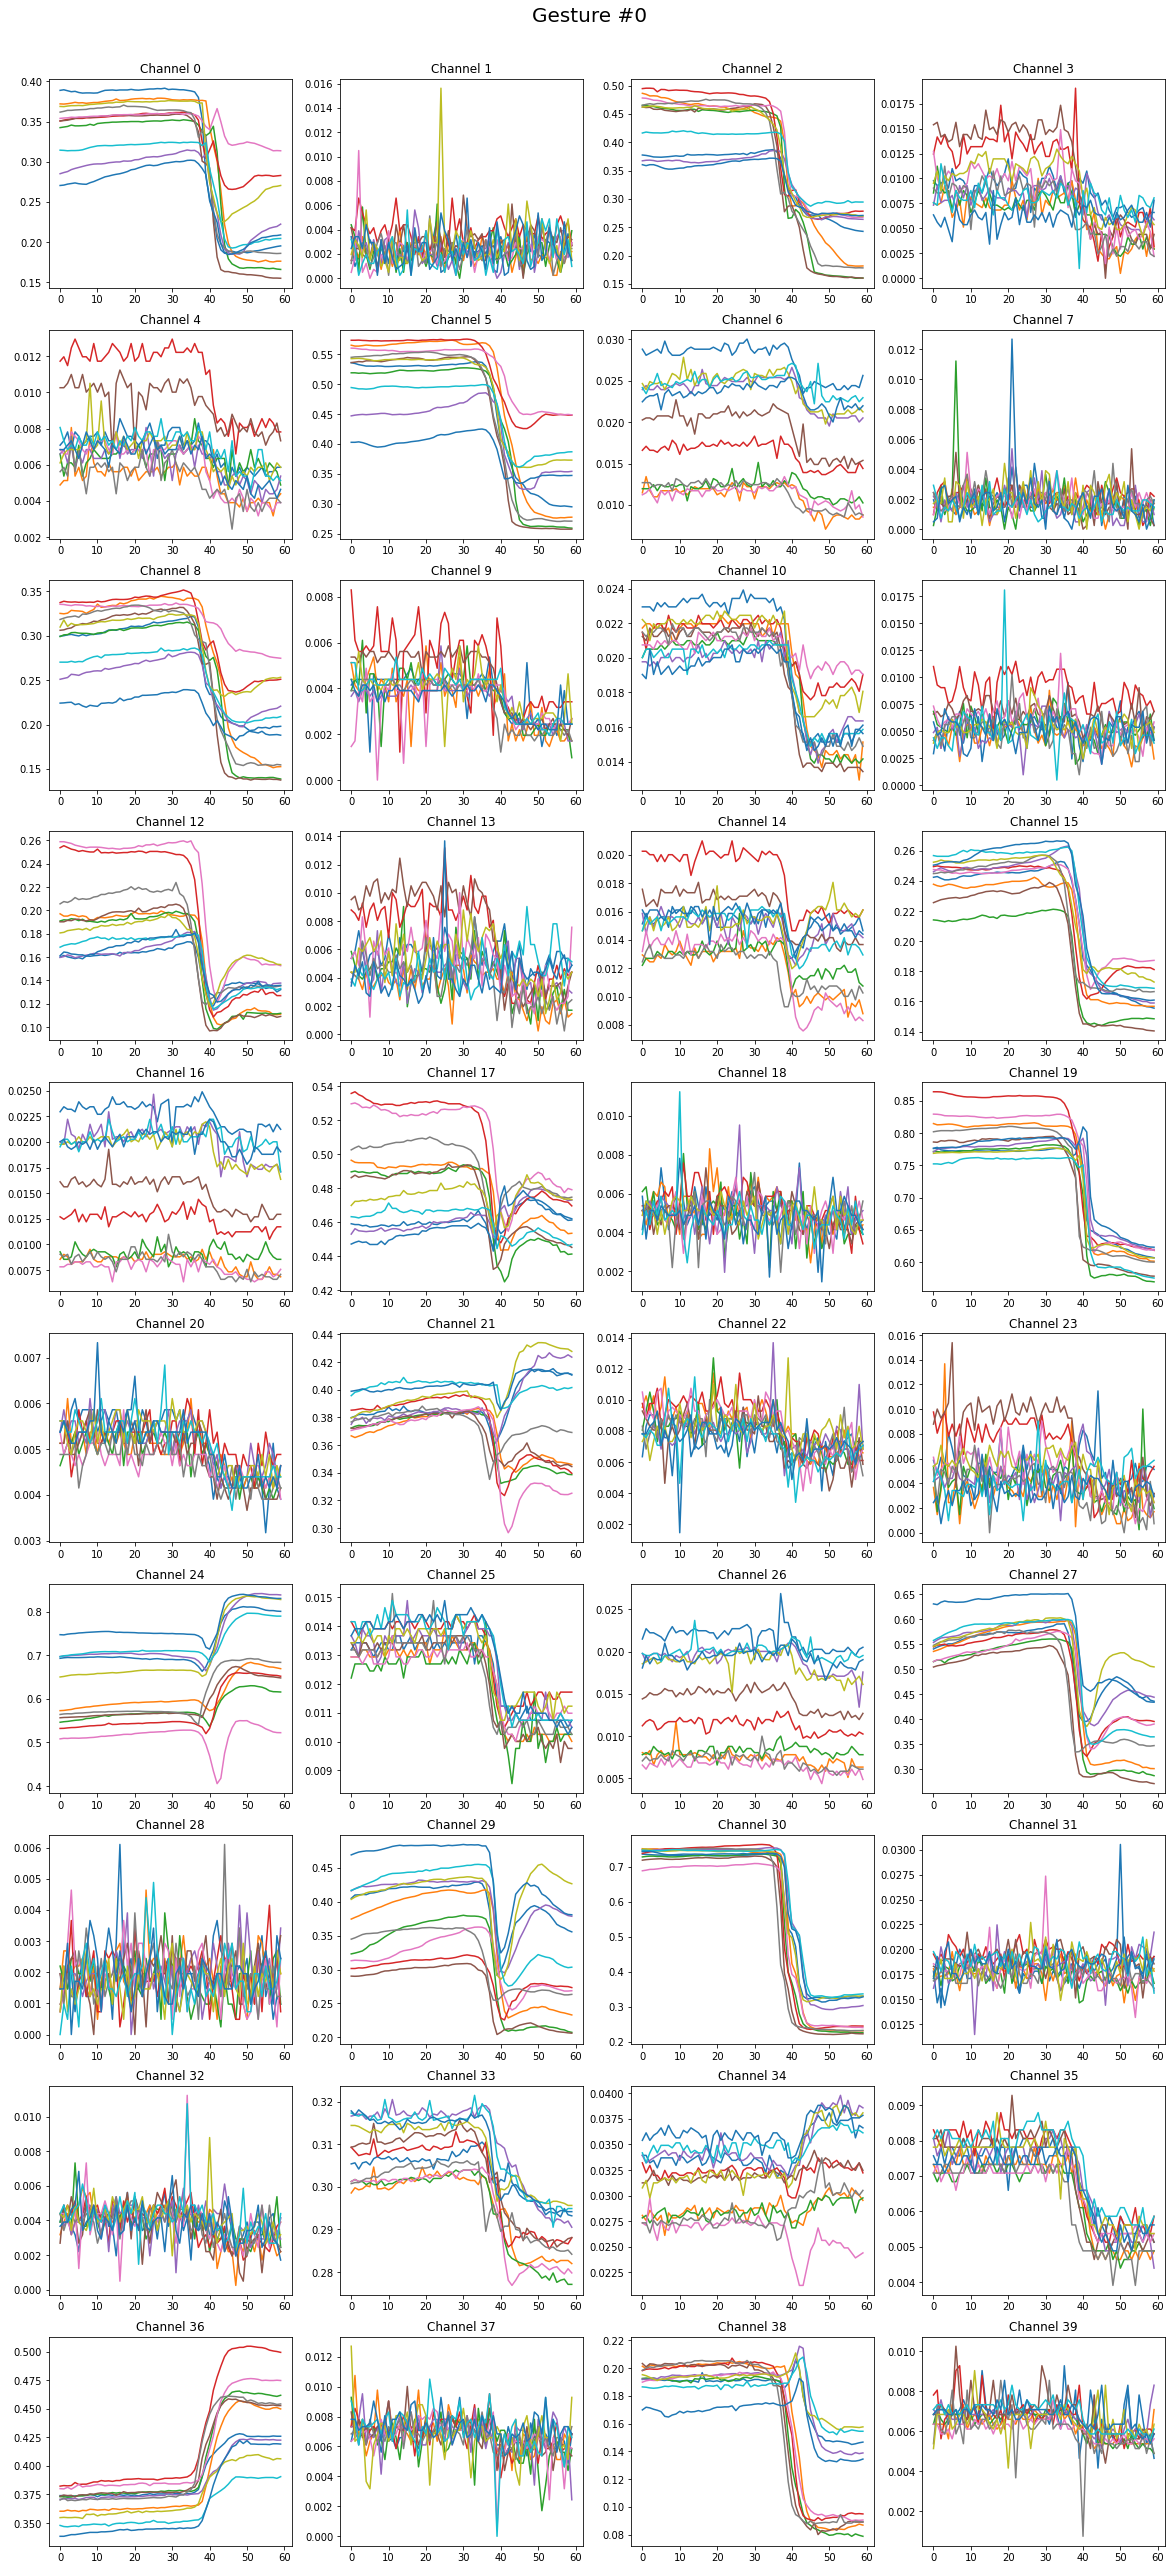

In [ ]:
# "0" - разгиб жеста "grab";
# "1" - разгиб жеста "ok";
# "2" - разгиб большого пальца;
# "3" - разгиб указательного пальца;
# "4" - разгиб жеста "пистолет";
# "5" - разгиб среднего пальца;
# "6" - разгиб безымянного пальца;
# "7" - разгиб мизинца;
# "8" - сгиб мизинца;
# "9" - сгиб безымянного пальца;
# "10" - сгиб среднего пальца;
# "11" - сгиб жеста "пистолет";
# "12" - сгиб указательного пальца;
# "13" - сгиб большого пальца;
# "14" - сгиб жеста "ok";
# "15" - сгиб жеста "grab";

# X_smoothed = X
X_smoothed = X #savgol_filter(X, 7, 3)
# cls_ls = list(range(16))
cls_ls = [0]

for k in range(1):
    # индексы одного класса в X
    cls = cls_ls[k] # метка жеста 
    cls_indices = np.asarray(y[y['Class'] == cls].index)

    num_of_channels = X_smoothed.shape[1]

    fig_n_cols = 4
    fig, axs = plt.subplots(num_of_channels // fig_n_cols + 1, fig_n_cols, 
                        figsize=(20, 5 * num_of_channels // fig_n_cols))
    fig.suptitle(t=f'Gesture #{cls}', y=0.9, fontsize=20);

    # строим графики всех наблюдений одного класса в X
    for i in range(num_of_channels):
        ax_curr = axs[i // fig_n_cols, i % fig_n_cols]
        ax_curr.set_title(f'Channel {i}')

        for j in range(len(cls_indices)):
            # X_sm = savgol_filter(X[cls_indices[j], i, :], 5, 3)
            d = np.diff(X_smoothed[cls_indices[j], i, :], n=0)
            ax_curr.plot(d, label=cls);
            # ax_curr.text(j*3, d[j*3], f'{j}');

del_emty_axes(axs)

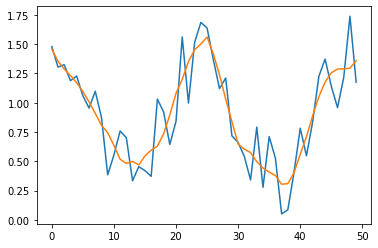

In [ ]:
k = 1.3
a = np.array(
    [
        [np.sin(np.linspace(0, 2*np.pi)+np.random.rand(50)/k), 
         np.cos(np.linspace(0, 2*np.pi))+np.random.rand(50)/k],
        [np.sin(np.linspace(0, 2*np.pi))**2+np.random.rand(50)/k, 
         np.cos(np.linspace(0, 2*np.pi))**2+np.random.rand(50)/k],
        [np.sin(np.linspace(0, 2*np.pi))**3+np.random.rand(50)/k, 
         np.cos(np.linspace(0, 2*np.pi))**3+np.random.rand(50)/k]
    ]
)

plt.plot(a[1, 1, :]);
# L = np.asarray([savgol_filter(a, 3, 2) for x in a])
# L.reshape(2, 3)
plt.plot(savgol_filter(a, 17, 5)[1, 1, :]);


## Развертка каналов по жестам

IndexError: ignored

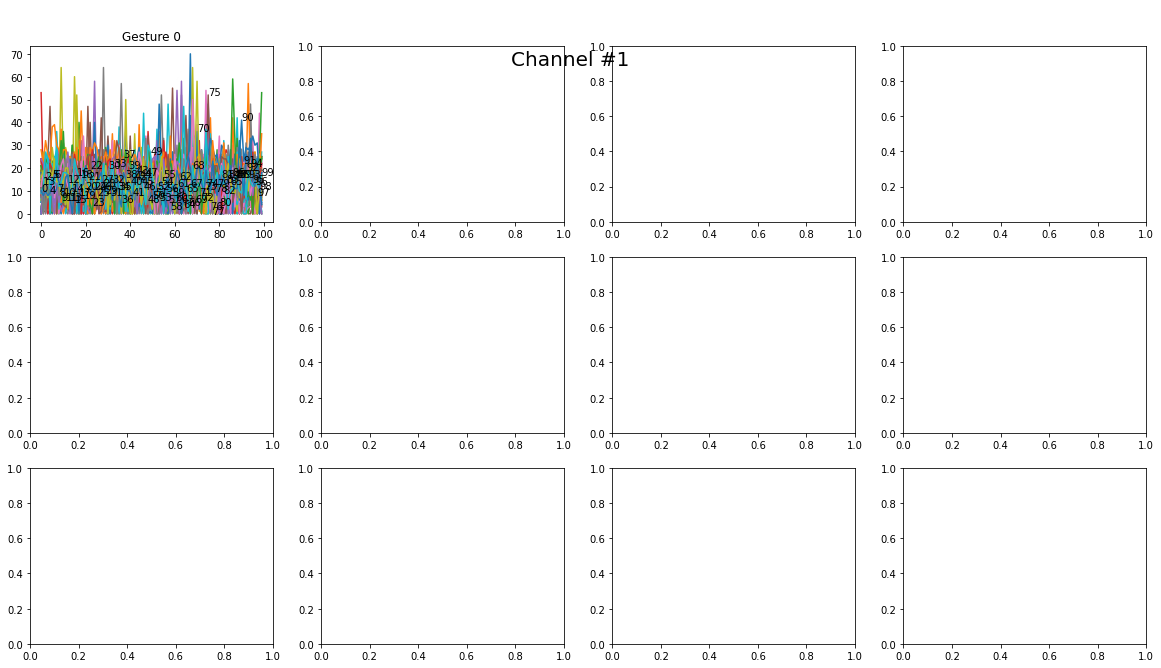

In [ ]:
channel_ls = [1, 7, 11, 18, 28, 31, 32, 37, 39]

for k in range(len(channel_ls)):
    # индексы одного класса в X
    channel = channel_ls[k] # метка жеста 
    
    num_of_channels = X.shape[1]

    n_of_classes = y['class'].nunique()

    fig_n_cols = 4
    fig, axs = plt.subplots(n_of_classes // fig_n_cols + 1, fig_n_cols, 
                        figsize=(20, 5 * n_of_classes // fig_n_cols))
    fig.suptitle(t=f'\n\nChannel #{channel}', y=0.93, fontsize=20);

    # строим графики всех наблюдений одного класса в X
    for i in range(n_of_classes):
        ax_curr = axs[i // fig_n_cols, i % fig_n_cols]
        ax_curr.set_title(f'Gesture {i}')
        cls_indices = np.asarray(y[y['class'] == i].index)
        
        # XG = np.zeros((len(cls_indices), 60)) #on to heatmap

        for j in range(len(cls_indices)):
            ax_curr.plot(X[cls_indices[j], channel, :], label=f'{j}'); #off to heatmap
            # XG[j, :] = X[cls_indices[j], channel, :] #on to heatmap
            # sns.heatmap(data=XG, ax=ax_curr, cbar=False, cmap='coolwarm'); #on to heatmap
            ax_curr.text(j, 
                         X[cls_indices[j],
                           channel,
                           j],
                         f'{j}'); #off to heatmap
        
    del_emty_axes(axs)

In [ ]:
len(cls_indices)

17950

In [ ]:
X[0, 0, :]

array([0.32495117, 0.32543945, 0.32495117, 0.32519531, 0.32568359,
       0.32568359, 0.32543945, 0.32568359, 0.32592773, 0.32568359,
       0.32495117, 0.32470703, 0.32348633, 0.32324219, 0.32250977,
       0.32226562, 0.32226562, 0.32226562, 0.32250977, 0.32250977,
       0.32177734, 0.32177734, 0.32177734, 0.32128906, 0.32080078,
       0.32055664, 0.32055664, 0.32006836, 0.31958008, 0.3190918 ,
       0.31835938, 0.31762695, 0.31689453, 0.31665039, 0.31689453,
       0.31665039, 0.31567383, 0.31201172, 0.30004883, 0.28100586,
       0.27392578, 0.24755859, 0.22509766, 0.21728516, 0.21508789,
       0.21386719, 0.21240234, 0.21069336, 0.20825195, 0.20556641,
       0.20385742, 0.20288086, 0.20214844, 0.2019043 , 0.20239258,
       0.203125  , 0.20336914, 0.20458984, 0.20556641, 0.20703125])

In [ ]:
# X[2, 0].shape
X[164, 0, :]

array([0.19873047, 0.19848633, 0.19897461, 0.19995117, 0.20019531,
       0.20092773, 0.20166016, 0.20336914, 0.20361328, 0.20239258,
       0.20288086, 0.20239258, 0.20361328, 0.20483398, 0.20532227,
       0.20483398, 0.20581055, 0.20727539, 0.20751953, 0.20776367,
       0.20776367, 0.20825195, 0.20947266, 0.21020508, 0.2109375 ,
       0.21118164, 0.21166992, 0.21264648, 0.21313477, 0.21362305,
       0.21484375, 0.21557617, 0.21606445, 0.21655273, 0.21679688,
       0.21826172, 0.21875   , 0.21923828, 0.2175293 , 0.21020508,
       0.19775391, 0.18945312, 0.18725586, 0.19042969, 0.19165039,
       0.19213867, 0.19287109, 0.19140625, 0.19091797, 0.19091797,
       0.19018555, 0.18896484, 0.18847656, 0.1875    , 0.18652344,
       0.18554688, 0.18505859, 0.18432617, 0.18383789, 0.18334961])